# Analyzing Evolving Job Requirements Using Machine Learning
Author: Matthew Huh


## Overview

Connecting people with prospective employers is quite a daunting task as it's very difficult to accurately gauge the supply and demand of positions over time. Employers may want to add or remove certain skillsets, and in order for people to find employment, they'll have to adjust their skillsets to accomodate those that employers are looking for. The component that this project will address is determining what skillsets employers are looking for in the broad realm of data science.

## About the Data

The data used for this capstone project has been obtained from Indeed, a job board that contains thousands of new listings every day and should provide an up-to-date collection that prospective data scientists will want to pay attention to. The data that will be extracted are the job's 
* title
* location
* company
* salary
* synopsis
* query

Associated web scraper script can be found at 
https://github.com/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Indeed%20Job%20Scraper.ipynb

## Research Question

The bulk of the analysis will be conducted by examining the synopsis of each posting, and determine what keywords we can identify with each query. Since this is for a data science course, the queries that I chose to examine are positions tha should be a good fit for the contents of this course, namely

* data analyst
* data scientist
* data engineer

As a result of creating this project, I hope to uncover what prospective employers are looking for in their candidates, which should paint a better picture of what each of these positions require.
## Packages

In [1]:
# Basic imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Machine Learning packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
import cufflinks as cf
import ipywidgets as widgets
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Create list of files from directory
filelist = os.listdir('data')

# Import the files
job_list = [pd.read_csv('data/' + file, index_col=False) for file in filelist]

#concatenate them together
job_data = pd.concat(job_list)

# Preview the data
job_data.head()

job_data.drop(['Unnamed: 0', 'Metro', 'URL'], 1, inplace=True)

C:\Users\nu\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




In [3]:
# Import the dataframe
job_data = pd.read_csv('job_board.csv', index_col=False)
job_data.drop(['Unnamed: 0', 'Metro'], 1, inplace=True)

In [4]:
# Let's check up on the size of our dataframe
job_data.shape

(565, 6)

In [5]:
# Preview the data
pd.options.display.max_colwidth = 200
job_data.head()

,Title,Location,Company,Salary,Synopsis,Query
0,TEMP DATA ANALYST .,"Peoria, IL",Hinduja Global Solutions,None,The Colgate Data Analyst is responsible for reviewing all contact data collected through all channels on a targeted product....,data+analyst
1,Data Analyst,"Nashville, TN",XSolis,None,XSOLIS is seeking to fill a full-time Data Analyst for our Analytics/Data Science team. Healthcare data experience is a plus....,data+analyst
2,Data Analyst,"Indianapolis, IN 46250",Robert Half Technology,"\r\n $45,000 - $65,000 a year",What you do as the Data Analyst:. 2+ years experience in a Data Analyst role. The Data Analyst will work Monday-Friday 8-5PM on this full time opportunity....,data+analyst
3,Data Analyst Apprentice,"Baltimore, MD",TranZed,"\r\n $30,000 - $50,000 a year","Data visualization skills (ex. The Data Analyst Apprentice will work closely with the IT, Operations, Sales, and Executive management teams....",data+analyst
4,Data Analyst Intern,"Chicago, IL 60604 (Loop area)",Klein Consulting,\r\n $15 - $20 an hour,We are seeking a Data Analyst to become an integral part of our team! Use data to understand business patterns and trends....,data+analyst


In [6]:
# Doing some data cleaning
for i, row in job_data.iterrows():
    
    # Clean up location column to format 'city, state'
    (job_data['Location'][i]) = ' '.join((job_data['Location'][i]).split(' ', 2)[:2]) 
    
    # Clean up summary column (Better, but doesn't completely remove all whitespace)
    (job_data['Synopsis'][i]) = (job_data['Synopsis'][i]).strip()

In [7]:
# Print number of unique categories for all non-numerical columns
job_data.select_dtypes(include=['object']).nunique()

Title       169
Location    153
Company     302
Salary       92
Synopsis    540
Query         3
dtype: int64

# Data Visualization

In [8]:
# Print out most common job titles and frequencies
job_data['Title'].value_counts().head(20)

Data Scientist                                        111
Data Analyst                                           67
Data Engineer                                          65
Junior Data Scientist                                  12
Junior Data Analyst                                     8
Data Scientist and Cognitive Engineer, Entry-Level      7
Big Data Engineer                                       7
Data Visualization Engineer                             6
Data Entry Analyst                                      6
Entry Level Data Analyst                                6
Data Analyst Intern                                     6
DATA SCIENTIST                                          4
Data Scientist w/ Watson Experience                     4
Data Scientist / Predictive Modeler                     4
Machine Learning Data Associate, Alexa AI               4
Data Center Engineer                                    4
Entry Level Business Analyst                            4
Junior Data En

In [9]:
# View 20 most frequent locations
location_data = job_data['Location'].value_counts()
location_data.head(20)

New York,           47
San Francisco,      32
Washington, DC      23
Seattle, WA         22
Santa Clara         15
San Jose,           15
United States       14
Austin, TX          11
Remote              11
Chicago, IL         10
McLean, VA          10
Baltimore, MD       10
Reston, VA           8
Houston, TX          8
Jersey City,         7
San Diego,           7
Indianapolis, IN     7
Los Angeles,         7
Detroit, MI          7
Arlington, VA        6
Name: Location, dtype: int64

In [10]:
# # Attempt at creating a bubble map using geopandas / plotly
# # Step 1: get geopandas to import
# # Step 2: create geodataframe with city, lat, long
# # Step 3: Plotly

# import geopandas
# import geolocator

# location = geolocator.geocode('New York')
# print(location.latitude)

# layout = dict(
#         title = '2014 US city populations<br>(Click legend to toggle traces)',
#         showlegend = True,
#         geo = dict(
#             scope='usa',
#             projection=dict( type='albers usa' ),
#             showland = True,
#             landcolor = 'rgb(217, 217, 217)',
#             subunitwidth=1,
#             countrywidth=1,
#             subunitcolor="rgb(255, 255, 255)",
#             countrycolor="rgb(255, 255, 255)"
#         ),
#     )

# fig = dict(data=cities, layout=layout)
# py.iplot(fig, validate=False, filename='d3-bubble-map-populations')

# lat = pd.Series()
# long = pd.Series()

# for i, row in location_data.iteritems():
#     print(i)
#     lat.append((geolocator.geocode(i)))
#     long.append((geolocator.geocode(i)))

In [11]:
# Cleans up salary data

# Create salary dataframe for postings with salary information
salary_data = job_data.replace(to_replace='None', value=np.nan).dropna()

# Removes words from salary data so that we can convert to numbers
salary_data = salary_data[(~salary_data.Salary.str.contains('an hour')) & (~salary_data.Salary.str.contains('a month'))
                   & (~salary_data.Salary.str.contains('a week')) & (~salary_data.Salary.str.contains('a day'))]
salary_data.Salary = salary_data.Salary.str.replace('a year', '').str.replace(',', '').str.replace('$', '')
salary_data.Salary = salary_data.Salary.str.replace('\(Indeed est.\)', '')

# Reduce ranges to single values
new_salaries = []
for i in salary_data.Salary:
    a = i.split('-')
    if len(a) == 2:
        new_salaries.append(np.mean([float(b) for b in a]))
    else:
        new_salaries.append(float(a[0]))        
salary_data.Salary = new_salaries

In [12]:
# Creates boxplots of the queries

data_analyst = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+analyst'],
    name = 'Data Analyst'
)
data_scientist = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+scientist'],
    name = 'Data Scientist'
)
data_engineer = go.Box(
    y=salary_data['Salary'].loc[salary_data['Query']=='data+engineer'],
    name = 'Data Engineer'
)
layout = go.Layout(
    title = 'Salary Comparison by Query'
)
data = [data_analyst,data_scientist,data_engineer]
        
fig = go.Figure(data=data,layout=layout)
py.offline.iplot(fig)

<div class="alert alert-block alert-warning">
1. Each salary was computed by converting non-annual salary rates to annual, and taking the average of all ranges. The actual minimum and maximum values are most likely lower and higher respectively.

2. Very few employers (<20%) on Indeed include the salary in the listing (meaning that the numbers shown above are likely higher than the actual numbers.
</div>

# Natural Language Processing

In [13]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [14]:
# Remove annoying punctuation from the articles
job_data['Synopsis'] = job_data.Synopsis.map(lambda x: text_cleaner(str(x)))

In [15]:
# Reduce all text to their lemmas
lemmatizer = WordNetLemmatizer()

for summary in job_data['Synopsis']:
    summary = lemmatizer.lemmatize(summary)

In [16]:
X = job_data['Synopsis']
y = job_data['Query']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Tf-idf Matrix

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the bag of words feature matrix
cvec = CountVectorizer(stop_words='english',ngram_range=(1, 3), min_df = .05)
cvec.fit(job_data["Synopsis"])

job_train = pd.DataFrame(cvec.transform(job_data["Synopsis"]).todense(),
                       columns=cvec.get_feature_names())

word_observe = pd.concat([job_train, job_data["Query"]], axis=1)
word_observe.head()

,analysis,analyst,analytics,analyze,business,data,data analysis,data analyst,data engineer,data scientist,...,science,scientist,scientists,support,team,tools,use,using,work,Query
0,0,1,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,data+analyst
1,0,1,1,0,0,3,0,1,0,0,...,1,0,0,0,1,0,0,0,0,data+analyst
2,0,3,0,0,0,3,0,3,0,0,...,0,0,0,0,0,0,0,0,1,data+analyst
3,0,1,0,0,0,2,0,1,0,0,...,0,0,0,0,0,0,0,0,1,data+analyst
4,0,1,0,0,1,2,0,1,0,0,...,0,0,0,0,1,0,1,0,0,data+analyst


In [18]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(lowercase=False, 
                          stop_words='english',
                          ngram_range=(1, 1), 
                          analyzer=u'word', 
                          max_df=.5, 
                          min_df=1,
                          max_features=150, 
                          vocabulary=None, 
                          binary=False)

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X_train)

job_train = pd.DataFrame(vectorizer.transform(job_data["Synopsis"]).todense(),
                       columns=vectorizer.get_feature_names())
job_train.head()

,AWS,Analyst,Analytics,As,Big,Business,Data,Develop,ETL,Engineer,...,transformation,trends,understand,use,using,various,visualization,work,working,years
0,0.0,0.419552,0.000000,0.0,0.0,0.0,0.256941,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.288944,0.396825,0.0,0.0,0.0,0.353908,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,0.0,0.672917,0.000000,0.0,0.0,0.0,0.412107,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.224306,0.0,0.285701
3,0.0,0.250958,0.000000,0.0,0.0,0.0,0.307383,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.338962,0.250958,0.0,0.000000
4,0.0,0.320685,0.000000,0.0,0.0,0.0,0.196393,0.0,0.0,0.0,...,0.0,0.448278,0.426364,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


In [19]:
# Creating tf-idf matrix
vectorizer = TfidfVectorizer(stop_words='english')
synopsis_tfidf = vectorizer.fit_transform(job_data['Synopsis'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=job_data['Query'].nunique()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 50

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                

In [21]:
from sklearn.decomposition import NMF

# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nnmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [22]:
# View top words identified by LSA and NNMF
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
                  LSA                  NNMF
0           data 57.1             data 6.35
0       analyst 14.46          analyst 1.99
0      engineer 13.92         engineer 1.79
0      business 11.44       experience 1.23
0    experience 11.08         business 1.12
0      analysis 11.01             work 0.92
0          work 10.91          analysis 0.9
0      analytics 9.84             team 0.87
0           team 9.43        analytics 0.85
0       scientist 8.4        scientist 0.79
0      scientists 7.4          looking 0.73
0    engineering 6.85            tools 0.71
0        science 6.85          develop 0.69
0          tools 6.79              big 0.66
0        looking 6.68          analyze 0.66
0       learning 6.62          sources 0.63
0        machine 6.51          seeking 0.61
0        develop 6.23            using 0.59
0            role 6.1             role 0.58
0          using 5.91            years 0.56
0        support 5.81       management 0.55
0            new 5.79  

In [23]:
# Generate stopwords for wordcloud
stopwords = set(STOPWORDS)
stopwords.update(['Data Analyst, Data Engineer, Data Scientist', 'data', 'analyst', 'will', 'seeking', 'including', 'using', 'looking'])

# Generate wordcloud
def wordcloud(text):
    wordcloud = WordCloud(stopwords=stopwords, max_words=50, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

data+analyst


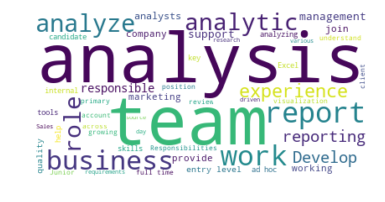

data+scientist


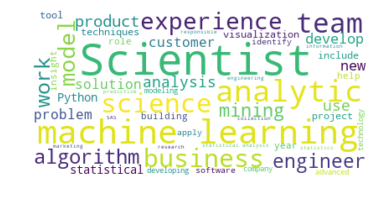

data+engineer


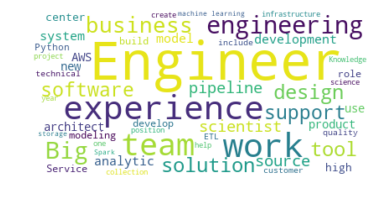

In [24]:
query_list = list(job_data.Query.unique())

for query in query_list:
    text = " ".join(synopsis for synopsis in job_data['Synopsis'].loc[job_data['Query']=='{}'.format(query)])
    print(str(query))
    wordcloud(text)

In [25]:
# Create keyword set with top words identified by LSA
keywords = set(topwords['LSA'].str.split(' ', 0).str[0])

# New dataframe with just the text and query
sentences = job_data[['Synopsis', 'Query']]

In [26]:
keywords

{'00',
 'advanced',
 'agile',
 'ai',
 'algorithms',
 'analysis',
 'analyst',
 'analysts',
 'analytics',
 'analyze',
 'apply',
 'architect',
 'artificial',
 'big',
 'building',
 'business',
 'center',
 'closely',
 'cognitive',
 'collaborate',
 'collection',
 'company',
 'computer',
 'contract',
 'core',
 'customer',
 'data',
 'deep',
 'degree',
 'department',
 'deploying',
 'develop',
 'developing',
 'directly',
 'domain',
 'efforts',
 'engineer',
 'engineering',
 'engineers',
 'equipment',
 'experience',
 'exploration',
 'help',
 'include',
 'including',
 'innovative',
 'intern',
 'join',
 'junior',
 'knowledge',
 'lead',
 'learning',
 'looking',
 'machine',
 'maintenance',
 'management',
 'managers',
 'member',
 'members',
 'mining',
 'modeling',
 'models',
 'needs',
 'new',
 'office',
 'operations',
 'pattern',
 'predictive',
 'problems',
 'processing',
 'product',
 'projects',
 'python',
 'qa',
 'quantitative',
 'recognition',
 'regression',
 'research',
 'responsibilities',
 'respo

In [27]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['synopsis'] = sentences['Synopsis']
    df['query'] = sentences['Query']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['synopsis']):
        
        # Populate the row with word counts.
        for word in common_words:
            df.loc[i, word] += 1
#             print(df)
            if i ==50:
                break
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [28]:
word_counts = bow_features(sentences, keywords)
word_counts.head()

Processing row 0
Processing row 500


,management,strong,directly,systems,office,help,statistical,visualization,ai,domain,...,junior,exploration,time,scientist,regression,analytics,needs,member,synopsis,query
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,The Colgate Data Analyst is responsible for reviewing all contact data collected through all channels on a targeted product....,data+analyst
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,XSOLIS is seeking to fill a full-time Data Analyst for our Analytics/Data Science team. Healthcare data experience is a plus....,data+analyst
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,What you do as the Data Analyst:. 2+ years experience in a Data Analyst role. The Data Analyst will work Monday-Friday 8-5PM on this full time opportunity....,data+analyst
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,"Data visualization skills (ex. The Data Analyst Apprentice will work closely with the IT, Operations, Sales, and Executive management teams....",data+analyst
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,We are seeking a Data Analyst to become an integral part of our team! Use data to understand business patterns and trends....,data+analyst


In [29]:
X = word_counts.drop(['synopsis','query'], 1)
y = word_counts['query']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [30]:
X_vector = job_data['Synopsis']

# Set up parameters for the vectorizer
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
# tokenize and build vocab
vectorizer.fit(X_vector)

# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

# encode document
vector = vectorizer.transform([text[0]])

# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'analyst': 41, 'responsible': 697, 'reviewing': 705, 'collected': 147, 'targeted': 818, 'product': 632, 'seeking': 735, 'time': 834, 'analytics': 45, 'science': 723, 'team': 820, 'healthcare': 379, 'experience': 309, 'plus': 600, 'years': 907, 'role': 709, 'work': 898, 'opportunity': 561, 'visualization': 886, 'skills': 751, 'ex': 300, 'closely': 139, 'operations': 559, 'sales': 715, 'executive': 304, 'management': 489, 'teams': 821, 'integral': 425, 'use': 865, 'understand': 859, 'business': 105, 'patterns': 583, 'trends': 851, 'assurance': 79, 'city': 128, 'creating': 192, 'reporting': 683, 'using': 870, 'bank': 89, 'repository': 686, 'looking': 478, 'businesses': 106, 'provide': 647, 'expertise': 316, 'drive': 255, 'growth': 369, 'retention': 701, 'hire': 384, 'analysts': 42, 'analyze': 46, 'interpret': 436, 'high': 382, 'volumes': 889, 'review': 704, 'anomalies': 49, 'analysis': 40, 'help': 380, 'improve': 403, 'safety': 713, 'customers': 201, 'large': 454, 'amounts': 38, 'need': 


[5.54683461 6.23998179 5.95229972 6.23998179 6.23998179 6.23998179
 6.23998179 5.39268393 5.95229972 6.23998179 5.39268393 6.23998179
 5.1413695  5.72915617 5.95229972 6.23998179 5.54683461 5.95229972
 5.39268393 6.23998179 5.39268393 5.95229972 5.72915617 5.03600899
 5.95229972 6.23998179 6.23998179 6.23998179 6.23998179 4.77364472
 5.95229972 5.39268393 5.39268393 6.23998179 4.16054025 6.23998179
 6.23998179 5.54683461 4.94069881 5.25915254 3.02110596 2.96914623
 4.3428618  4.85368743 4.94069881 3.21145969 3.81223355 6.23998179
 4.69953675 6.23998179 6.23998179 5.95229972 6.23998179 6.23998179
 6.23998179 5.39268393 5.25915254 5.54683461 6.23998179 4.69953675
 5.54683461 5.95229972 6.23998179 4.77364472 5.95229972 5.95229972
 4.94069881 5.95229972 5.39268393 6.23998179 6.23998179 6.23998179
 5.95229972 6.23998179 6.23998179 6.23998179 4.77364472 5.95229972
 6.23998179 6.23998179 6.23998179 5.95229972 5.72915617 5.1413695
 5.72915617 4.77364472 5.54683461 5.39268393 6.23998179 6.2399

 5.95229972 4.04275721]
(1, 908)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 

In [31]:
job_train.head()

,AWS,Analyst,Analytics,As,Big,Business,Data,Develop,ETL,Engineer,...,transformation,trends,understand,use,using,various,visualization,work,working,years
0,0.0,0.419552,0.000000,0.0,0.0,0.0,0.256941,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,0.0,0.288944,0.396825,0.0,0.0,0.0,0.353908,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,0.0,0.672917,0.000000,0.0,0.0,0.0,0.412107,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.224306,0.0,0.285701
3,0.0,0.250958,0.000000,0.0,0.0,0.0,0.307383,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.338962,0.250958,0.0,0.000000
4,0.0,0.320685,0.000000,0.0,0.0,0.0,0.196393,0.0,0.0,0.0,...,0.0,0.448278,0.426364,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000


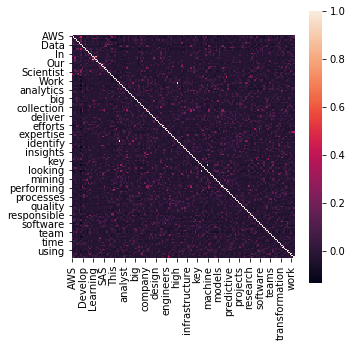

In [33]:
# Creates a correlation matrix among the predictor variables
plt.rcParams['figure.figsize'] = [5,5]

corr = job_train.corr()
sns.heatmap(corr, vmax = 1, square = True)
plt.show()

['Machine', 'hoc', 'machine']

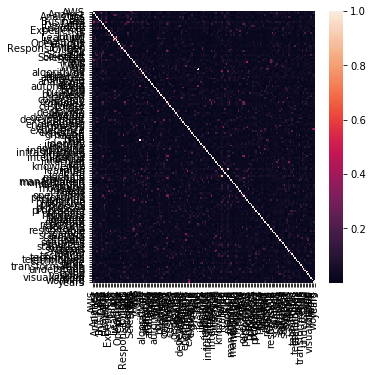

In [34]:
corr = job_train.corr().abs() 
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

#Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

#Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)] 
to_drop

# Clustering

In [35]:
X_train.head()

,management,strong,directly,systems,office,help,statistical,visualization,ai,domain,...,recognition,efforts,junior,exploration,time,scientist,regression,analytics,needs,member
263,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
473,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
141,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
409,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [39]:
y_train.head()

263    data+scientist
473     data+engineer
5        data+analyst
141      data+analyst
409     data+engineer
Name: query, dtype: object

In [41]:
y_pred0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
# Calulate predicted values
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=20)
y_pred0 = kmeans.fit_predict(job_train)

pd.crosstab(y, y_pred0)

col_0,0,1,2
query,,,
data+analyst,100,66,3
data+engineer,105,64,8
data+scientist,138,35,46


# Training the Model

### Random Forest

In [ ]:
rfc = ensemble.RandomForestClassifier()
rfc_train = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=-1)
print('Random forest classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(rfc_train.mean(), rfc_train.std()*2))

### Logistic Regression

In [ ]:
lr = LogisticRegression()
lr_train = cross_val_score(lr, features, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (without clustering): {:.5f}(+/- {:.2f})\n'.format(lr_train.mean(), lr_train.std()*2))

lr_train_c = cross_val_score(lr, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Logistic regression score (with clustering): {:.5f}(+/- {:.2f})'.format(lr_train_c.mean(), lr_train_c.std()*2))

### Gradient Boosting

In [ ]:
gbc = ensemble.GradientBoostingClassifier()
gbc_train = cross_val_score(gbc, features, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (without clustering): {:.5f}(+/- {:.2f})\n'.format(gbc_train.mean(), gbc_train.std()*2))

gbc_train_c = cross_val_score(gbc, X_train_cluster, y_train, cv=5, n_jobs=-1)
print('Gradient boosting classifier score (with clustering): {:.5f}(+/- {:.2f})'.format(gbc_train_c.mean(), gbc_train_c.std()*2))